# Unveiling Bias in Gender Violence Perception on Italian Social Media

## Importing Libraries

In [1]:
%pip install clean-text

Note: you may need to restart the kernel to use updated packages.


In [1]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import spacy
from cleantext import clean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [3]:
!python -m spacy download it_core_news_sm

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
      --------------------------------------- 0.2/13.0 MB 5.0 MB/s eta 0:00:03
     - -------------------------------------- 0.5/13.0 MB 5.2 MB/s eta 0:00:03
     -- ------------------------------------- 0.7/13.0 MB 5.2 MB/s eta 0:00:03
     --- ------------------------------------ 1.0/13.0 MB 5.4 MB/s eta 0:00:03
     ---- ----------------------------------- 1.3/13.0 MB 5.6 MB/s eta 0:00:03
     ---- ----------------------------------- 1.6/13.0 MB 5.6 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/13.0 MB 5.4 MB/s eta 0:00:03
     ------ --------------------------------- 2.1/13.0 MB 5.5 MB/s eta 0:00:02
     ------- -------------------------------- 2.4/13.0 MB 5.6 MB/s eta 0:00:02
     ------- -------------------------------- 2.6/13.0 MB 5.5 MB/s eta 0:00:02
     -------- ------------------------------- 2.8/13.0 MB 5.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/13.0 MB 5

## Reading and Cleaning Data

### Read Df

This data frame comes from extensive and hard scraping on Nitter, one of the last available resources to scrape Twitter without rate limits and high expenses. However, because of the instability of the various instances, we are not sure the results will be easily replicated if trying to run again the twitter.ipynb script. 

In [2]:
# read the data
df = pd.read_csv('twitter_data_ext.csv')

In [3]:
# drop the first column
# df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,Apr 19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,Apr 19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,Apr 19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,Apr 19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,Apr 19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


In [6]:
# check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40921 entries, 0 to 40920
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user      40921 non-null  object
 1   username  40921 non-null  object
 2   date      40921 non-null  object
 3   text      40921 non-null  object
 4   comments  40921 non-null  int64 
 5   retweets  40921 non-null  object
 6   quotes    40921 non-null  int64 
 7   likes     40921 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.5+ MB


The dates of 2024 have been saved with just day and month, therefore we need to add the year

In [4]:
# add the year to all the dates of 2024
df['date'] = df['date'].apply(lambda x: x + ' 2024' if len(x) < 10 else x)

In [5]:
# convert the date to datetime
df['date'] = pd.to_datetime(df['date'])

In [7]:
# clean the text column
df['text'] = df['text'].apply(lambda x: str(x).replace('\n', ' '))

In [8]:
# first five rows
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,2024-04-19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,2024-04-19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,2024-04-19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,2024-04-19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,2024-04-19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


This is the cleaned final data frame!

## Exploratory Data Analysis

### Polarization event

We chose as a polarization event the "Cecchettin case", that greatly moved public opinion regarding the hot topic of violence on women in italy.

In [9]:
# create a variable for the polarizing event
pol_event = dt.datetime(2023, 11, 11)

### Simple Tweet Count

In [10]:
# group the data by date
count_by_date = df.groupby('date').count()
count_by_date.head()

,user,username,text,comments,retweets,quotes,likes
date,,,,,,,
2022-02-16,15,15,15,15,15,15,15
2022-02-17,24,24,24,24,24,24,24
2022-02-18,19,19,19,19,19,19,19
2022-02-19,11,11,11,11,11,11,11
2022-02-20,4,4,4,4,4,4,4


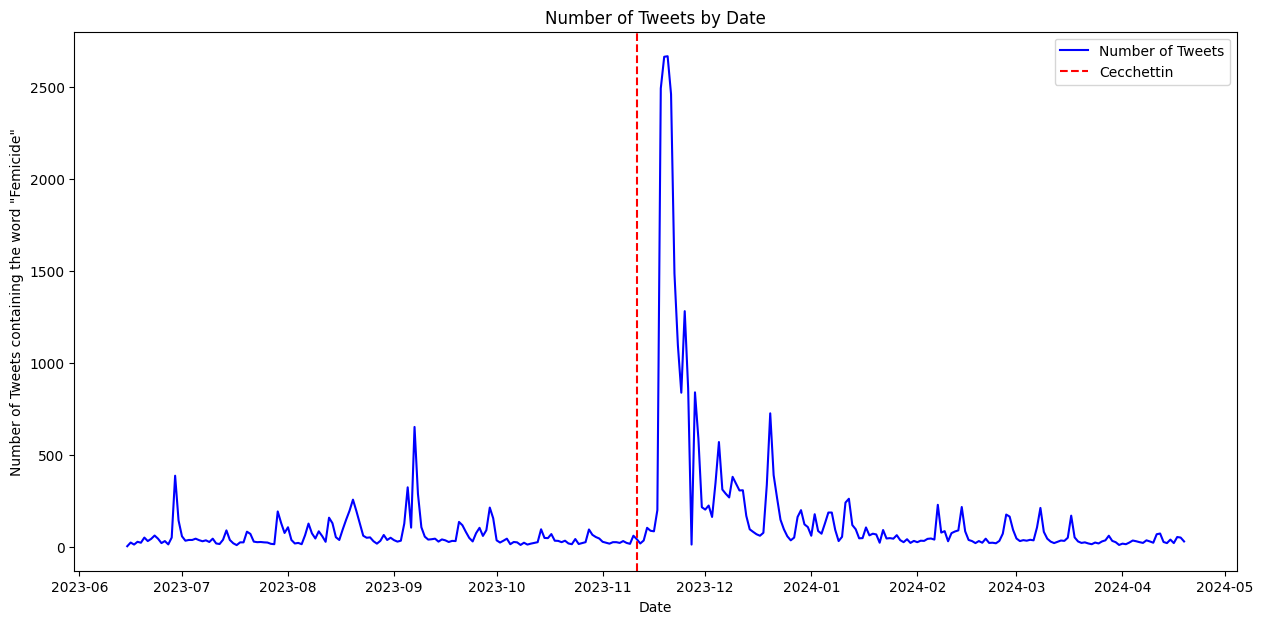

In [15]:
# plot the number of tweets by date
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(count_by_date.index, count_by_date['text'], label='Number of Tweets', color='blue')
ax.axvline(pol_event, color='red', linestyle='--', label='Cecchettin')
ax.set_title('Number of Tweets by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets containing the word "Femicide"')
ax.legend()

plt.show()

### Number of Different Users

In [11]:
# count the number of different users
n_different_users = df['user'].nunique()
print(f'There are {n_different_users} different users in the dataset (that contains {len(df)} tweets)')

There are 23743 different users in the dataset (that contains 62624 tweets)


There are 17773 different users in the dataset (that contains 40921 tweets)

In [12]:
# list of all different users
different_users = df['user'].unique()
different_users

array(['Sciking', '💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫',
       'pubblicanow.it', ...,
       '.•.°• 🦦|| young royals & liceali gay era °.•', 'Lucia Guarano',
       'Laura Garavini'], dtype=object)

In [21]:
users_df = df.groupby('user').agg(list).reset_index()
users_df['username'] = users_df['username'].apply(lambda x: x[0])
users_df.head()

,user,username,date,text,comments,retweets,quotes,likes,hashtags
0,raffaele52,@raffaele521,[2023-11-21 00:00:00],[La sua conoscenza del femminicidio è straordi...,[0],[0],[0],[0],[nan]
1,Shana Loricco,@shanaloricco201,[2023-12-05 00:00:00],"[Parole forti, chiare. Giuste. #LorenzoGasparr...",[0],[0],[0],[0],"[[#LorenzoGasparrini, #willita, #femminicidio,..."
2,"""Lehodettocresci"" E io sono cresciuta🌈🌻",@nagioia08,"[2023-10-04 00:00:00, 2023-06-01 00:00:00, 202...",[D'altronde Pi3rsilvio ha cacciato la d'urso p...,"[0, 0, 2, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]","[ 8, 0, 0, 3]","[nan, nan, nan, nan]"
3,"""seneca&pericle""",@senecaepericle,[2023-01-24 00:00:00],[Non parliamo poi del femminicidio...],[0],[0],[0],[0],[nan]
4,# claudia ✧ 🔭,@308bangtan,[2023-08-01 00:00:00],"[in realtà penalmente parlando non è uguale, u...",[0],[0],[0],[0],[nan]


In [22]:
users_df['n_tweets'] = users_df['text'].apply(lambda x: len(x))

### Number of Tweets per User

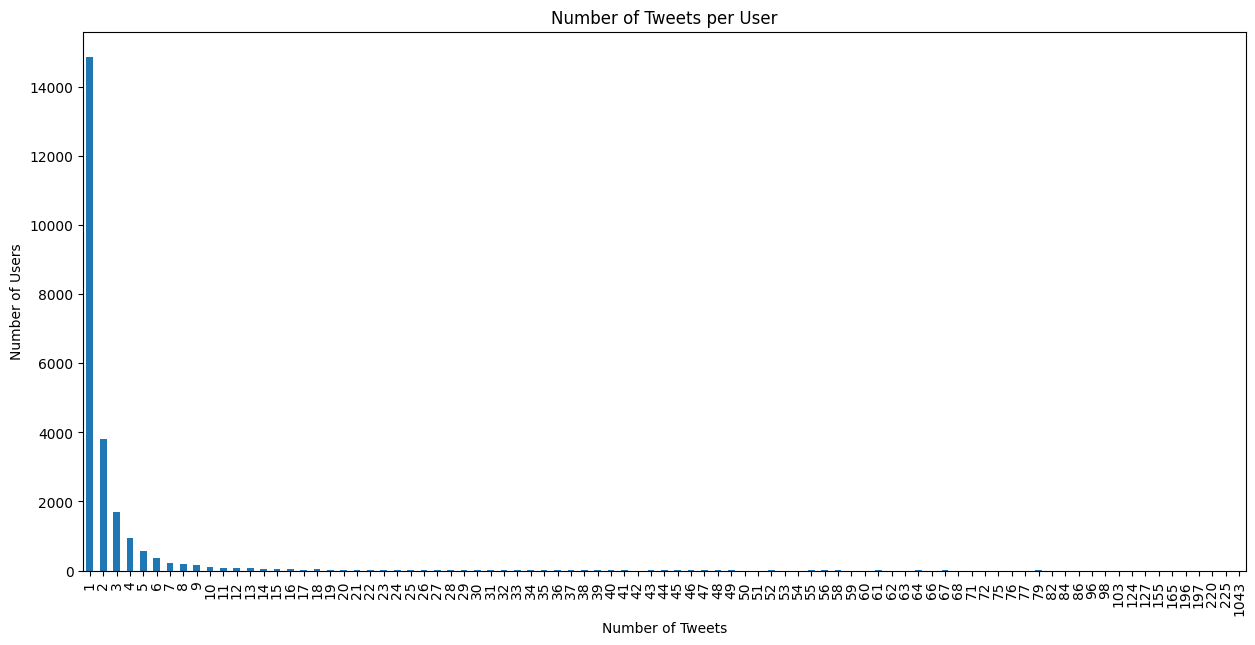

In [27]:
fig, ax = plt.subplots(figsize=(15, 7))
users_df['n_tweets'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Number of Tweets per User')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Users')
# ax.set_xlim(-1, 23)

plt.show()

In [35]:
with open('users.csv', 'w') as f:
    users = users_df.sort_values('n_tweets', ascending=False)['username'].values
    for user in users:
        f.write(user + ',' + '\n')

### Label Institutions

In [36]:
usernames = [
    "@repubblica", "@LaStampa", "@Corriere", "@ilmessaggeroit", "@ilgiornale", "@fattoquotidiano",
    "@TV2000it", "@SkyTG24", "@Tg3web", "@MediasetTgcom24", "@tg2rai", "@TgLa7",
    "@Radio1Rai", "@rtl1025", "@RaiNews", "@RadioVoceVicina", "@RADIOBRUNO1", "@RadioCapital_fm",
    "@fanpage", "@globalistIT", "@Agenzia_Ansa", "@LaPresse_news", "@direpuntoit", "@Adnkronos",
    "@VanityFairIt", "@361_magazine", "@InsertoMagazine",
    "@giallolorca", "@genderedform", "@GQ_Italia", "@Internazionale",
    "@fisco24_info", "@bizcommunityit", "@magzinemag",
    "@Noviolenzadonne", "@NonunadimenoF", "@amnestyitalia",
    "@bizcommunityit", "@AgenPolitica", "@Femminicidio",
    "@Movimento5Stelle", "@leganord", "@ForzaItalia", "@DemocraziaAtea"
]

# usernames_2 = 

In [81]:
def is_in_list(x, lis):
    if x in lis:
        return 1
    else:
        return 0

In [85]:
df['is_institution'] = df['username'].apply(lambda x: is_in_list(x, usernames))

<AxesSubplot: >

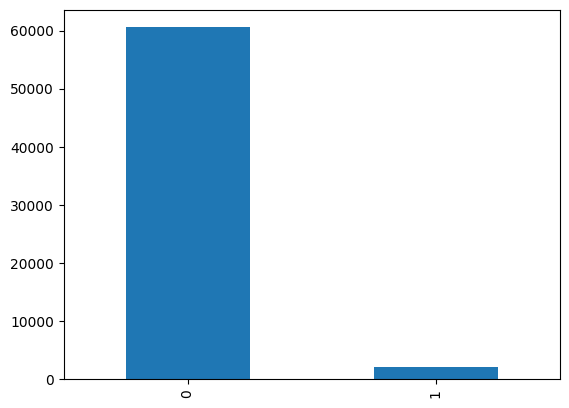

In [86]:
df['is_institution'].value_counts().plot(kind = 'bar')

## Data Processing

### Split Dates

In [87]:
pol_event_date = dt.datetime(2023, 11, 11)
df['after'] = 0
df.loc[df['date'] > pol_event_date, 'after'] = 1

### Create Hashtag Column

In [88]:
# function to get hashtags
def get_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    if hashtags != []:
        return re.findall(r'#\w+', text)
    else:
        return np.nan

In [89]:
df['hashtags'] = df['text'].apply(get_hashtags)

In [90]:
df.loc[df['hashtags'].notna(), 'hashtags'].reset_index(drop=True)

0                            [#femminicidio, #femminicidi]
1                                               [#Raiplay]
2                                          [#Femminicidio]
3                    [#Attualità, #Italia, #UltimeNotizie]
4                                   [#Sardegna, #violenza]
                               ...                        
22072    [#humanrights, #Imrali, #Turkey, #FreeOcalanNo...
22073            [#humanrights, #Turkey, #Kurds, #podcast]
22074                                     [#FreeOcalanNow]
22075                        [#eutanasialegale, #medioevo]
22076         [#uominimaltrattanti, #femminicidio, #donne]
Name: hashtags, Length: 22077, dtype: object

### Clean Tweets

In [91]:
def remover(text, chars = ['@', '#', 'http']):

    starting_chars = '|'.join(chars)
    for word in text.split():
        if re.match(f'{starting_chars}[A-za-z]+', word):
            text = text.replace(word, '')
        
    return text

In [92]:
def remove_apostrophe(text):
    return text.replace("'", " ")

In [93]:
def remove_words_under(text, n=2):
    return ' '.join([word for word in text.split() if len(word) > n])

In [94]:
def duster(text):
    return remove_words_under(remove_apostrophe(remover(text)))

In [95]:
df['clean_text'] = df['text'].apply(lambda x: duster(x).lower())
df['clean_text'] = df['clean_text'].apply(lambda x: clean(x, no_urls=True, no_emails=True, no_phone_numbers=True, no_numbers=True, no_digits=True, no_currency_symbols=True, no_punct=True, no_emoji=True, replace_with_url='', replace_with_email='', replace_with_phone_number='', replace_with_number='', replace_with_digit='', replace_with_currency_symbol='', replace_with_punct=''))

In [96]:
df['clean_text'].head()

0    solo donne possono parlare aborto solo gli uom...
1                                                     
2    paesi baschi aiuto annuale per gli orfani femm...
3    ambasciata italia vienna aderisce alla campagn...
4    bhe speriamo che non sia per qualche femminici...
Name: clean_text, dtype: object

In [97]:
nlp = spacy.load('it_core_news_sm')

In [100]:
texts_before = df.loc[(df['after'] == 0) & (df['is_institution'] == 0), 'clean_text'].values
texts_after = df.loc[(df['after'] == 1) & (df['is_institution'] == 0), 'clean_text'].values
documents_before = list(nlp.pipe(texts_before))
documents_after = list(nlp.pipe(texts_after))

In [101]:
corpus_before = [[word.text for word in doc if not word.is_stop] for doc in documents_before]
corpus_after = [[word.text for word in doc if not word.is_stop] for doc in documents_after]

In [102]:
print(len(corpus_before), len(corpus_after))

29715 30832


In [103]:
from gensim.models import word2vec
import os

w2v_before = word2vec.Word2Vec(corpus_before, vector_size=100, window=5, min_count=1, workers=os.cpu_count())
w2v_after = word2vec.Word2Vec(corpus_after, vector_size=100, window=5, min_count=1, workers=os.cpu_count())

In [104]:
w2v_before.wv.most_similar('giustizia')

[('inutile', 0.9995319247245789),
 ('gente', 0.9995076060295105),
 ('atto', 0.9995054602622986),
 ('sicuramente', 0.9994710087776184),
 ('twitter', 0.9994612336158752),
 ('direi', 0.9994602799415588),
 ('risposta', 0.9994598627090454),
 ('propaganda', 0.9994434714317322),
 ('chissa', 0.9994407892227173),
 ('vivere', 0.9994282126426697)]

In [105]:
w2v_after.wv.most_similar('giustizia')

[('diretta', 0.9993073344230652),
 ('avra', 0.9991934299468994),
 ('cara', 0.9988837242126465),
 ('vicenda', 0.9987579584121704),
 ('news', 0.9987444877624512),
 ('ricordate', 0.9986198544502258),
 ('riesco', 0.9985950589179993),
 ('cuore', 0.998579740524292),
 ('particolari', 0.9983978271484375),
 ('piange', 0.998395562171936)]

In [106]:
def similarity_before_after(words, model_before, model_after):
    if type(words) == str:
        try:
            vec_before = model_before.wv[words]
            vec_after = model_after.wv[words]
            similarity = cosine_similarity([vec_before], [vec_after])
            return {words: similarity[0][0]}
        except KeyError:
            return {words: 'word not in vocabulary'}
    else:
        similarities = {}
        for word in words:
            try:
                vec_before = model_before.wv[word]
                vec_after = model_after.wv[word]
                similarity = cosine_similarity([vec_before], [vec_after])
                similarities[word] = similarity[0][0]
            except KeyError:
                similarities[word] = 'word not in vocabulary'
        return similarities

In [107]:
word = 'femminicidio'
similarity = similarity_before_after(word, w2v_before, w2v_after)
print(f'the similarity between the word {word} before and after the event is {similarity[word]}')

the similarity between the word femminicidio before and after the event is 0.7266804575920105


In [108]:
polarizing_words = ['destra', 'sinistra', 'donna', 'aborto', 'giustizia', 'femminicidio', 'omicidio', 'violenza']
similarities = similarity_before_after(polarizing_words, w2v_before, w2v_after)
for word in similarities:
    print(f'the similarity between the word {word} before and after the event is {similarities[word]}')

the similarity between the word destra before and after the event is 0.7894886136054993
the similarity between the word sinistra before and after the event is 0.8033135533332825
the similarity between the word donna before and after the event is 0.6422968506813049
the similarity between the word aborto before and after the event is 0.7619597911834717
the similarity between the word giustizia before and after the event is 0.7999809384346008
the similarity between the word femminicidio before and after the event is 0.7266804575920105
the similarity between the word omicidio before and after the event is 0.6911720633506775
the similarity between the word violenza before and after the event is 0.6220027804374695


In [99]:
vocab_before = list(w2v_before.wv.key_to_index)
X_before = w2v_before.wv[vocab_before]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_before)

In [100]:
vocab_after = list(w2v_after.wv.key_to_index)
X_after = w2v_after.wv[vocab_after]
tsne = TSNE(n_components=2)
X_tsne_after = tsne.fit_transform(X_after)

In [101]:
df_before = pd.DataFrame(X_tsne, index=vocab_before, columns=['x', 'y'])
df_after = pd.DataFrame(X_tsne_after, index = vocab_after, columns = ['x', 'y'])

In [102]:
df_before = df_before.loc[polarizing_words]
df_after = df_after.loc[polarizing_words]

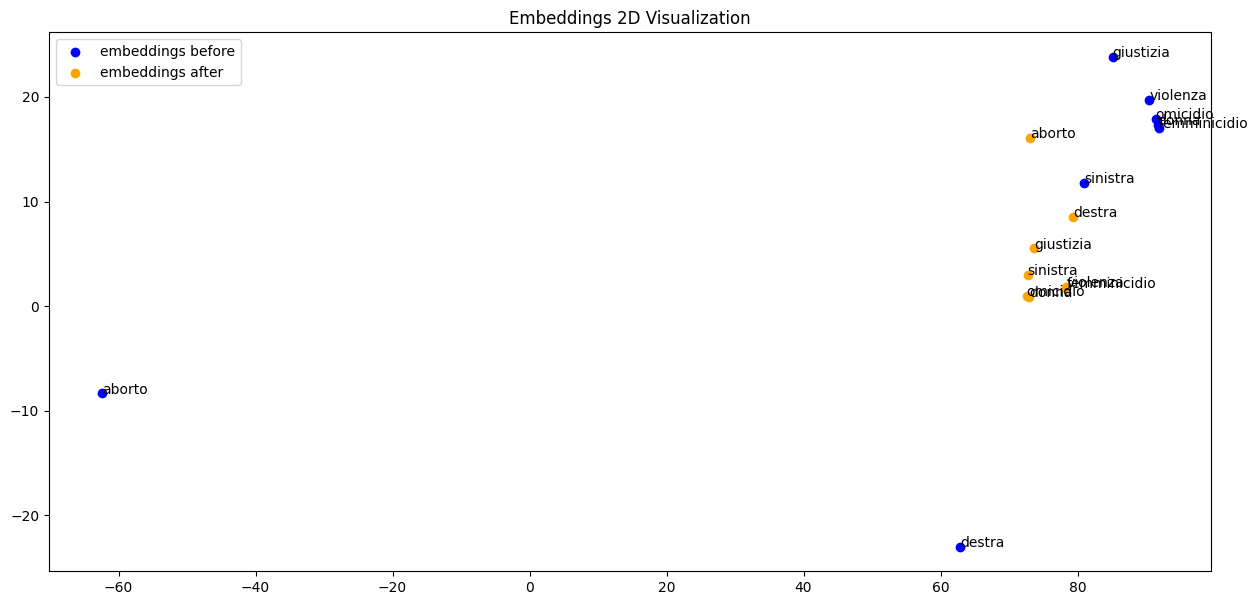

In [103]:
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df_before['x'], df_before['y'], color = 'blue', label = 'embeddings before')
ax.scatter(df_after['x'], df_after['y'], color = 'orange', label = 'embeddings after')
ax.legend()

for word, pos in df_before.iterrows():
    ax.annotate(word, pos)
for word, pos in df_after.iterrows():
    ax.annotate(word, pos)
plt.title('Embeddings 2D Visualization')
plt.show()

## Word Comparison

In [109]:
from copy import deepcopy

#define a function that converts the word2vec models into numpy arrays
def w2v_to_numpy (model):
  model.wv.fill_norms()
  embeddings = deepcopy (model.wv.get_normed_vectors())
  idx = {w:i for i, w in enumerate (model.wv.index_to_key)}
  iidx = {i:w for i, w in enumerate (model.wv.index_to_key)}

  return embeddings, (idx, iidx)

#define a function that returns the nearest neighbors of a query
def near_neighbors (embs, query, word2rownum, rownum2word, k=5):
  sims = np.dot (embs, embs[word2rownum[query]])
  indices = np.argsort (-sims)

  return [(rownum2word[index], sims[index]) for index in indices[1:k+1]]

In [110]:
#define functions to make meaningful comparisons of words across models
def procrustes(A, B):
    U, _, Vt = np.linalg.svd(B.T.dot(A))
    return U.dot(Vt)

def intersect_vocab (idx1, idx2):
  common = idx1.keys() & idx2.keys()
  common_vocab = [v for v in common]

  common_idx, common_iidx = {v:i for i,v in enumerate (common_vocab)}, {i:v for i,v in enumerate (common_vocab)}
  return common_vocab, (common_idx, common_iidx)

def align_matrices (mat1, mat2, idx1, idx2):
  common_vocab, (common_idx, common_iidx) = intersect_vocab (idx1, idx2)
  row_nums1 = [idx1[v] for v in common_vocab]
  row_nums2 = [idx2[v] for v in common_vocab]

  remapped_mat1 = mat1[row_nums1, :]
  remapped_mat2 = mat2[row_nums2, :]
  omega = procrustes (remapped_mat1, remapped_mat2)

  rotated_mat2 = np.dot (remapped_mat2, omega)

  return remapped_mat1, rotated_mat2, (common_idx, common_iidx)

In [111]:
before_embs, (before_idx, before_iidx) = w2v_to_numpy(w2v_before)
after_embs, (after_idx, after_iidx) = w2v_to_numpy(w2v_after)
before_aligned_embs, after_aligned_embs, (common_idx, common_iidx) = align_matrices (before_embs, after_embs, before_idx, after_idx)

In [112]:
#define the sets of words
victim_words = ['vittima', 'assassinata','innocente']
murderer_words = ['omicida', 'assassino', 'mostro', 'colpevole','delinquente', 'criminale']
emotional_neg_words = ['gelosia', 'tradimento', 'rifiuto','vendetta']
emotional_pos_words = ['passione','felici', 'amore', 'rispetto']
crude_words = ['sangue', 'cadavere', 'strangolata', 'violenza', 'tortura']
modal_words = ['dovere', 'necessario', 'bisogno', 'occorre', 'urgente', 'essenziale', 'fondamentale']
patriarchy_words = ['patriarcato', 'ingiustizia', 'oppressione', 'discriminazione','sessismo', 'retrogrado']


## Across models comparison (how words evolved over time)

In [113]:
#victim related words comparison across models
victim_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in victim_words]
for w,score in sorted (victim_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

innocente 0.99696124
assassinata 0.9921971
vittima 0.9458394


In [114]:
#murderer related words comparison across models
murderer_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in murderer_words]
for w,score in sorted (murderer_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

colpevole 0.9947967
mostro 0.9912563
omicida 0.9896606
assassino 0.98656446
criminale 0.98538995
delinquente 0.97481


In [115]:
#negative emotional words comparison across models
emotional_neg_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in emotional_neg_words]
for w,score in sorted (emotional_neg_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

rifiuto 0.9941734
vendetta 0.9938046
tradimento 0.98907393
gelosia 0.982276


In [116]:
#positive emotional words comparison across models
emotional_pos_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in emotional_pos_words]
for w,score in sorted (emotional_pos_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

passione 0.992391
rispetto 0.9806243
amore 0.9780126
felici 0.97441906


In [117]:
#crude words comparison across models
crude_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in crude_words]
for w,score in sorted (crude_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

sangue 0.99745995
cadavere 0.9920637
tortura 0.9734747
strangolata 0.93438196
violenza 0.91892606


In [118]:
#modal words comparison across models
modal_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in modal_words]
for w,score in sorted (modal_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

necessario 0.9981343
dovere 0.99766976
urgente 0.99672526
occorre 0.99639016
bisogno 0.9963419
fondamentale 0.9945413
essenziale 0.9768123


In [119]:
#patriarchy words comparison across models
patriarchy_words_sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in patriarchy_words]
for w,score in sorted (patriarchy_words_sims, key=lambda x:x[1], reverse=True):
  print (w, score)

sessismo 0.9873878
discriminazione 0.97903574
oppressione 0.9786676
ingiustizia 0.9744378
patriarcato 0.9645715
retrogrado 0.8918998


We now compare the most and least similar words between the models, across the entire vocabulary

In [120]:
sims = [(w, before_aligned_embs[common_idx[w]].dot(after_aligned_embs[common_idx[w]])) for w in common_idx.keys()]

print('Most similar words')
for w, sim in sorted (sims, key=lambda x:x[1], reverse=True)[0:10]:
  print (w, sim)
print()
print()
print('Least similar words')
for w, sim in sorted (sims, key=lambda x:x[1], reverse=False)[0:10]:
  print (w, sim)

Most similar words
difesa 0.99937576
que 0.99923515
the 0.9992098
campagna 0.999163
gioco 0.99914473
pubblico 0.9991371
morale 0.99913526
devo 0.9991251
giudice 0.9991187
informazione 0.9990941


Least similar words
sprofondato -0.6642332
ininterrotta -0.59940434
assegnazione -0.5965273
legare -0.54276407
ballate -0.48681614
licenzia -0.48200777
distorte -0.47844994
prestato -0.47112533
definirti -0.43621525
aggrapparsi -0.41785565


## Within model comparison

In [121]:
#nearest neighbors for victim related words
for word in victim_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "vittima" in the before corpus
('altra', 0.99523413)
('bologna', 0.9936305)
('rapina', 0.9925574)
('frosinone', 0.9923877)
('villabate', 0.99233633)

Near neighbors for "vittima" in the after corpus
('ennesima', 0.98707414)
('lennesima', 0.9838154)
('ragazza', 0.9767756)
('povera', 0.9731071)
('figlia', 0.9710413)


Near neighbors for "assassinata" in the before corpus
('strangolata', 0.9989439)
('corpo', 0.99873775)
('scomparsa', 0.9986553)
('marocchino', 0.9983131)
('ristorante', 0.99830425)

Near neighbors for "assassinata" in the after corpus
('voleva', 0.99883676)
('ammazzato', 0.99844056)
('vicina', 0.99800634)
('bovolenta', 0.9977194)
('pio', 0.99770224)


Near neighbors for "innocente" in the before corpus
('dettagli', 0.99917316)
('bagno', 0.9990854)
('chiede', 0.9990185)
('finita', 0.99892735)
('quartiere', 0.99889624)

Near neighbors for "innocente" in the after corpus
('amore', 0.998114)
('lassassino', 0.99797195)
('fratello', 0.9979496)
('pazzo', 0.99794

In [122]:
#nearest neighbors for murderer related words
for word in murderer_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "omicida" in the before corpus
('lassassino', 0.9997102)
('ragazzo', 0.9996988)
('bambina', 0.99962354)
('procura', 0.9995761)
('indagini', 0.9994669)

Near neighbors for "omicida" in the after corpus
('vivo', 0.99938124)
('esce', 0.9993708)
('racconta', 0.99931383)
('caccia', 0.9992863)
('matrimonio', 0.9991511)


Near neighbors for "assassino" in the before corpus
('giovane', 0.9980505)
('strada', 0.9977523)
('ammazzata', 0.9977367)
('sorrento', 0.99756175)
('martina', 0.9975612)

Near neighbors for "assassino" in the after corpus
('parente', 0.9965827)
('assassinata', 0.99618626)
('ammazzato', 0.9961464)
('giudicato', 0.99607646)
('voleva', 0.9959579)


Near neighbors for "mostro" in the before corpus
('procura', 0.99934924)
('fermo', 0.9993211)
('zona', 0.9992646)
('lassassino', 0.99924266)
('dettagli', 0.9992176)

Near neighbors for "mostro" in the after corpus
('kosovaro', 0.9976151)
('lassassino', 0.99740446)
('pazzo', 0.99728507)
('presunto', 0.9967133)
('bam

In [123]:
#nearest neighbors for positive emotional words
for word in emotional_pos_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "passione" in the before corpus
('nome', 0.99891615)
('racconta', 0.99888325)
('prossimo', 0.99887705)
('dato', 0.9987905)
('episodio', 0.99876165)

Near neighbors for "passione" in the after corpus
('feto', 0.99657357)
('decide', 0.996464)
('sente', 0.9962879)
('incidente', 0.9962245)
('immigrato', 0.9961881)


Near neighbors for "felici" in the before corpus
('potere', 0.9982819)
('politici', 0.9982095)
('son', 0.9982072)
('simili', 0.9981826)
('classe', 0.99814415)

Near neighbors for "felici" in the after corpus
('saputo', 0.9972989)
('notte', 0.9972612)
('rosa', 0.99725884)
('torino', 0.9972299)
('segni', 0.9972203)


Near neighbors for "amore" in the before corpus
('simbolo', 0.9988678)
('sicuro', 0.99881244)
('rischio', 0.9985287)
('settimana', 0.9984257)
('capisco', 0.99841344)

Near neighbors for "amore" in the after corpus
('fratello', 0.9984598)
('pazzo', 0.99818677)
('stavolta', 0.9981233)
('ama', 0.9981172)
('innocente', 0.998114)


Near neighbors for "r

In [124]:
#nearest neighbors for negative emotional words
for word in emotional_neg_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "gelosia" in the before corpus
('veneto', 0.99858713)
('tragedia', 0.99812186)
('annunciato', 0.99780965)
('chiama', 0.9977408)
('botte', 0.99768037)

Near neighbors for "gelosia" in the after corpus
('uccido', 0.9977863)
('individuo', 0.9976141)
('ammazzi', 0.9968363)
('considerata', 0.99657714)
('ammazza', 0.9958007)


Near neighbors for "tradimento" in the before corpus
('raptus', 0.9988786)
('sangue', 0.998827)
('cuore', 0.9988128)
('deciso', 0.9986876)
('farci', 0.99868643)

Near neighbors for "tradimento" in the after corpus
('questioni', 0.9979576)
('comprendere', 0.99792373)
('gay', 0.9978795)
('devi', 0.99771804)
('pericolo', 0.99756277)


Near neighbors for "rifiuto" in the before corpus
('situazioni', 0.9988467)
('provvedimenti', 0.9987526)
('denunciate', 0.99873483)
('riesce', 0.9987325)
('mamme', 0.99871767)

Near neighbors for "rifiuto" in the after corpus
('accettare', 0.9992494)
('malato', 0.9989482)
('malattia', 0.998863)
('condizioni', 0.99882483)
(

In [125]:
#nearest neighbors for crude words
for word in crude_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "sangue" in the before corpus
('testa', 0.999658)
('cuore', 0.9996248)
('napoli', 0.9995539)
('domenica', 0.9995414)
('giudizio', 0.99950063)

Near neighbors for "sangue" in the after corpus
('sapeva', 0.9992089)
('servizio', 0.99912715)
('colpito', 0.9990448)
('veniva', 0.9986624)
('avvocato', 0.9985667)


Near neighbors for "cadavere" in the before corpus
('voleva', 0.9995544)
('corpo', 0.99932843)
('tolto', 0.99928355)
('geloso', 0.9991995)
('cinzia', 0.9991752)

Near neighbors for "cadavere" in the after corpus
('voleva', 0.99883974)
('bastardo', 0.99875903)
('fandaj', 0.9986427)
('chiamava', 0.99859804)
('ergastolo', 0.9984501)


Near neighbors for "strangolata" in the before corpus
('assassinata', 0.9989439)
('fratello', 0.9986645)
('romina', 0.99857354)
('corpo', 0.9985691)
('marinella', 0.99856055)

Near neighbors for "strangolata" in the after corpus
('marito', 0.9945512)
('coltellate', 0.9886355)
('moglie', 0.98703957)
('talamelli', 0.9860331)
('andria', 0.

In [126]:
#nearest neighbors for modal words
for word in modal_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "dovere" in the before corpus
('verita', 0.9992653)
('chiedere', 0.9991181)
('popolo', 0.9990754)
('civilta', 0.9990675)
('portano', 0.9990555)

Near neighbors for "dovere" in the after corpus
('amici', 0.9994116)
('migliore', 0.99933946)
('culo', 0.9993268)
('giro', 0.9992748)
('commento', 0.9991821)


Near neighbors for "necessario" in the before corpus
('frutto', 0.99941254)
('relazioni', 0.99934846)
('battaglia', 0.99919796)
('discussione', 0.99919534)
('risposte', 0.9991813)

Near neighbors for "necessario" in the after corpus
('impegno', 0.99936354)
('stasera', 0.99926007)
('arte', 0.9992367)
('devo', 0.9992269)
('commento', 0.9992237)


Near neighbors for "bisogno" in the before corpus
('questione', 0.99965334)
('reati', 0.9996419)
('dovrebbero', 0.99961746)
('vogliamo', 0.9996071)
('fatti', 0.9996003)

Near neighbors for "bisogno" in the after corpus
('veramente', 0.99950296)
('piano', 0.9994252)
('anzi', 0.99927217)
('dibattito', 0.99913466)
('unico', 0.9990

In [127]:
#nearest neighbors for patriarchy words
for word in patriarchy_words:
  print (f'Near neighbors for "{word}" in the before corpus')
  for item in near_neighbors (before_embs, word, before_idx, before_iidx, k=5):
    print (item)
  print ()
  print (f'Near neighbors for "{word}" in the after corpus')
  for item in near_neighbors (after_embs, word, after_idx, after_iidx, k=5):
    print (item)
  print()
  print()

Near neighbors for "patriarcato" in the before corpus
('dicono', 0.99953103)
('tanti', 0.9993787)
('serie', 0.9992654)
('ovvero', 0.9992255)
('questione', 0.9992151)

Near neighbors for "patriarcato" in the after corpus
('risolto', 0.9897187)
('stupro', 0.9887841)
('punta', 0.98769045)
('radicato', 0.98693156)
('sistemico', 0.986095)


Near neighbors for "ingiustizia" in the before corpus
('studio', 0.9973844)
('dover', 0.9973844)
('situazioni', 0.9973228)
('ovunque', 0.99727315)
('riesce', 0.99727046)

Near neighbors for "ingiustizia" in the after corpus
('nome', 0.99136424)
('siccome', 0.9911503)
('legale', 0.9908906)
('sento', 0.9906934)
('finira', 0.99041843)


Near neighbors for "oppressione" in the before corpus
('vogliamo', 0.997119)
('pedofilia', 0.9970892)
('bisogno', 0.99696344)
('bastano', 0.99692464)
('numeri', 0.9968344)

Near neighbors for "oppressione" in the after corpus
('tossica', 0.99425757)
('sessista', 0.99410546)
('deriva', 0.9940328)
('provenienza', 0.99336356)
(